
# STEP 1: GET THAT DATA



In [0]:
import pandas as pd
import numpy as np
## GLOBAL WK 2
train_file = "https://raw.githubusercontent.com/danielcaraway/data/master/covid19-global-forecasting-week-2/train.csv"
test_file = "https://raw.githubusercontent.com/danielcaraway/data/master/covid19-global-forecasting-week-2/test.csv"
sub_file = "https://raw.githubusercontent.com/danielcaraway/data/master/covid19-global-forecasting-week-2/submission.csv"

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
sub = pd.read_csv(sub_file)

# STEP 2: PREP THAT DATA

* Deal with states + countries
* Deal with datetimes
* Deal with categoricals (LabelEncoder)


In [0]:
subset = train.sample(n=500)

In [14]:
subset

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
2152,3241,NaN,Burkina Faso,2020-03-02,0.0,0.0
15094,22847,California,US,2020-03-08,0.0,0.0
4248,6425,Inner Mongolia,China,2020-02-15,68.0,0.0
12675,19204,NaN,Qatar,2020-01-25,0.0,0.0
3696,5601,Guizhou,China,2020-01-22,1.0,0.0
...,...,...,...,...,...,...
15851,24012,Iowa,US,2020-02-02,0.0,0.0
18449,27936,NaN,Ukraine,2020-02-26,0.0,0.0
18746,28403,Gibraltar,United Kingdom,2020-01-24,0.0,0.0
6906,10443,NaN,Eswatini,2020-03-04,0.0,0.0


In [0]:
# train = subset.copy()
def use_country(state, country):
  if pd.isna(state):
    return country
  else:
    return state

train['Province_State'] = train.apply(lambda x: use_country(x['Province_State'], x['Country_Region']), axis=1)
test['Province_State'] = test.apply(lambda x: use_country(x['Province_State'], x['Country_Region']), axis=1)

In [0]:
train_d = pd.get_dummies(train)
test_d = pd.get_dummies(test)

In [23]:
train_dummies

,Id,ConfirmedCases,Fatalities,Province_State_Afghanistan,Province_State_Alabama,Province_State_Alaska,Province_State_Alberta,Province_State_Algeria,Province_State_Angola,Province_State_Anhui,Province_State_Antigua and Barbuda,Province_State_Argentina,Province_State_Arizona,Province_State_Armenia,Province_State_Australian Capital Territory,Province_State_Azerbaijan,Province_State_Bahamas,Province_State_Bangladesh,Province_State_Barbados,Province_State_Beijing,Province_State_Belarus,Province_State_Belize,Province_State_Bhutan,Province_State_Bosnia and Herzegovina,Province_State_Brazil,Province_State_British Columbia,Province_State_Brunei,Province_State_Bulgaria,Province_State_Burkina Faso,Province_State_Cabo Verde,Province_State_California,Province_State_Cambodia,Province_State_Cameroon,Province_State_Cayman Islands,Province_State_Chad,Province_State_Channel Islands,Province_State_Chile,Province_State_Colombia,Province_State_Colorado,Province_State_Congo (Brazzaville),...,Date_2020-02-17,Date_2020-02-18,Date_2020-02-19,Date_2020-02-20,Date_2020-02-21,Date_2020-02-22,Date_2020-02-23,Date_2020-02-24,Date_2020-02-25,Date_2020-02-26,Date_2020-02-27,Date_2020-02-28,Date_2020-02-29,Date_2020-03-01,Date_2020-03-02,Date_2020-03-03,Date_2020-03-04,Date_2020-03-05,Date_2020-03-06,Date_2020-03-07,Date_2020-03-08,Date_2020-03-09,Date_2020-03-10,Date_2020-03-11,Date_2020-03-12,Date_2020-03-13,Date_2020-03-14,Date_2020-03-15,Date_2020-03-16,Date_2020-03-17,Date_2020-03-18,Date_2020-03-19,Date_2020-03-20,Date_2020-03-21,Date_2020-03-22,Date_2020-03-23,Date_2020-03-24,Date_2020-03-25,Date_2020-03-26,Date_2020-03-27
2152,3241,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15094,22847,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4248,6425,68.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12675,19204,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3696,5601,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15851,24012,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18449,27936,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18746,28403,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6906,10443,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# STEP 3: MODEL THAT DATA
* GridSearchCV
* XGBRegressor

In [0]:
from sklearn.model_selection import GridSearchCV 
import time 
param_grid = {'n_estimators': [1000]}

def gridSearchCV(model, X_Train, y_Train, param_grid, cv=10, scoring='neg_mean_squared_error'): 
  start = time.time()

In [0]:
X_Train = train.copy()
y1_Train = X_Train['ConfirmedCases']
y2_Train = X_Train['Fatalities']

In [0]:
from xgboost import XGBRegressor

model = XGBRegressor()
model1 = gridSearchCV(model, X_Train, y1_Train, param_grid, 10, 'neg_mean_squared_error') 
model2 = gridSearchCV(model, X_Train, y2_Train, param_grid, 10, 'neg_mean_squared_error')

In [0]:
countries = set(X_Train['Country_Region'])

#models_C = {}
#models_F = {}

df_out = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = set(X_Train['Province_State'])
    # states = X_Train.loc[X_Train.Country == country, :].State.unique()
    #print(country, states)
    # check whether string is nan or not
    for state in states:
        X_Train_CS = X_Train.loc[(X_Train.Country == country) & (X_Train.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities']]
        
        y1_Train_CS = X_Train_CS.loc[:, 'ConfirmedCases']
        y2_Train_CS = X_Train_CS.loc[:, 'Fatalities']
        
        X_Train_CS = X_Train_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_Train_CS.Country = le.fit_transform(X_Train_CS.Country)
        X_Train_CS['State'] = le.fit_transform(X_Train_CS['State'])
        
        X_Test_CS = X_Test.loc[(X_Test.Country == country) & (X_Test.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        
        X_Test_CS_Id = X_Test_CS.loc[:, 'ForecastId']
        X_Test_CS = X_Test_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_Test_CS.Country = le.fit_transform(X_Test_CS.Country)
        X_Test_CS['State'] = le.fit_transform(X_Test_CS['State'])
        
        #models_C[country] = gridSearchCV(model, X_Train_CS, y1_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        #models_F[country] = gridSearchCV(model, X_Train_CS, y2_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        
        model1 = XGBRegressor(n_estimators=1000)
        model1.fit(X_Train_CS, y1_Train_CS)
        y1_pred = model1.predict(X_Test_CS)
        
        model2 = XGBRegressor(n_estimators=1000)
        model2.fit(X_Train_CS, y2_Train_CS)
        y2_pred = model2.predict(X_Test_CS)
        
        df = pd.DataFrame({'ForecastId': X_Test_CS_Id, 'ConfirmedCases': y1_pred, 'Fatalities': y2_pred})
        df_out = pd.concat([df_out, df], axis=0)
    # Done for state loop
# Done for country Loop

# SIDEQUEST: More on XGBoost

In [0]:
b_train = train.copy()
b_test = test.copy()

In [36]:
b_train_y1 = b_train['ConfirmedCases']
b_train_y2 = b_train['Fatalities']
b_train_X = b_train.drop(['ConfirmedCases','Fatalities'], axis=1)
b_train_X

,Id,Province_State,Country_Region,Date
2152,3241,Burkina Faso,Burkina Faso,2020-03-02
15094,22847,California,US,2020-03-08
4248,6425,Inner Mongolia,China,2020-02-15
12675,19204,Qatar,Qatar,2020-01-25
3696,5601,Guizhou,China,2020-01-22
...,...,...,...,...
15851,24012,Iowa,US,2020-02-02
18449,27936,Ukraine,Ukraine,2020-02-26
18746,28403,Gibraltar,United Kingdom,2020-01-24
6906,10443,Eswatini,Eswatini,2020-03-04


In [37]:
b_train_X_d = pd.get_dummies(b_train_X)
b_train_X_d

,Id,Province_State_Afghanistan,Province_State_Alabama,Province_State_Alaska,Province_State_Alberta,Province_State_Algeria,Province_State_Angola,Province_State_Anhui,Province_State_Antigua and Barbuda,Province_State_Argentina,Province_State_Arizona,Province_State_Armenia,Province_State_Australian Capital Territory,Province_State_Azerbaijan,Province_State_Bahamas,Province_State_Bangladesh,Province_State_Barbados,Province_State_Beijing,Province_State_Belarus,Province_State_Belize,Province_State_Bhutan,Province_State_Bosnia and Herzegovina,Province_State_Brazil,Province_State_British Columbia,Province_State_Brunei,Province_State_Bulgaria,Province_State_Burkina Faso,Province_State_Cabo Verde,Province_State_California,Province_State_Cambodia,Province_State_Cameroon,Province_State_Cayman Islands,Province_State_Chad,Province_State_Channel Islands,Province_State_Chile,Province_State_Colombia,Province_State_Colorado,Province_State_Congo (Brazzaville),Province_State_Congo (Kinshasa),Province_State_Connecticut,...,Date_2020-02-17,Date_2020-02-18,Date_2020-02-19,Date_2020-02-20,Date_2020-02-21,Date_2020-02-22,Date_2020-02-23,Date_2020-02-24,Date_2020-02-25,Date_2020-02-26,Date_2020-02-27,Date_2020-02-28,Date_2020-02-29,Date_2020-03-01,Date_2020-03-02,Date_2020-03-03,Date_2020-03-04,Date_2020-03-05,Date_2020-03-06,Date_2020-03-07,Date_2020-03-08,Date_2020-03-09,Date_2020-03-10,Date_2020-03-11,Date_2020-03-12,Date_2020-03-13,Date_2020-03-14,Date_2020-03-15,Date_2020-03-16,Date_2020-03-17,Date_2020-03-18,Date_2020-03-19,Date_2020-03-20,Date_2020-03-21,Date_2020-03-22,Date_2020-03-23,Date_2020-03-24,Date_2020-03-25,Date_2020-03-26,Date_2020-03-27
2152,3241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15094,22847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4248,6425,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12675,19204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3696,5601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15851,24012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18449,27936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18746,28403,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6906,10443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
[22:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean cross-validation score: -70.40
[22:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:54:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
K-fold CV average score: -107.07
MSE: 36809.57
RMSE: 191.86


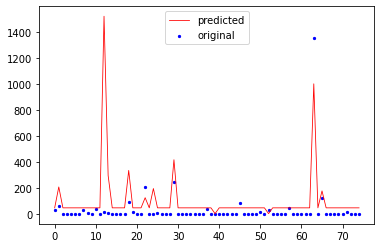

In [40]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import numpy as np
 
boston = load_boston()
# x, y = boston.data, boston.target

x,y = b_train_X_d, b_train_y1
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)

xgbr = xgb.XGBRegressor()
print(xgbr)

xgbr.fit(xtrain, ytrain)
 
# - cross validataion 
scores = cross_val_score(xgbr, xtrain, ytrain, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

x_ax = range(len(ytest))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()


In [29]:
boston.data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [31]:
boston.data.shape

(506, 13)

In [39]:
boston.target.shape

(506,)